<a href="https://colab.research.google.com/github/joaodpcm/MDA/blob/preprocessing_data_david/classifier_model_mda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages


In [1]:
# Import libraries
'''!pip install pandas-profiling
!pip install ydata-profiling
!pip install geopy
!pip install autoviz
!pip install matplotlib
!pip install -U textblob
!pip install statsmodels
!pip install missingno
!python -m textblob.download_corpora
!pip install missingpy
!pip install scikit-learn
!pip install sklearn'''
import numpy as np 
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import os
import sklearn

# Clone repository

In [2]:
#Accessing GitHub repository
!git clone <https://github.com/joaodpcm/MDAgit>

/bin/bash: -c: line 0: syntax error near unexpected token `newline'
/bin/bash: -c: line 0: `git clone <https://github.com/joaodpcm/MDAgit>'


In [5]:
# Setting package for drive
'''!pip install pyDrive
from google.colab import files'''
# Set path to the directory containing the meta dataset
%pip install openpyxl
path_copy_meteo = "meteo_data/data_final_meteo.csv"
df_meteo = pd.read_csv(path_copy_meteo)
path_copy_noise = "noise_data/events_noise2.xlsx"
df_noise = pd.read_excel(path_copy_noise)

  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


# Data Consistency

In [6]:
df_noise = df_noise.rename(columns={"startTime": "DATEUTC", "comp": "target"})

In [7]:
df = df_meteo.merge(df_noise, how='inner', on='DATEUTC')

In [8]:
df['DATEUTC'] = pd.to_datetime(df['DATEUTC'])

In [9]:
df['nameday'] = df['DATEUTC'].dt.dayofweek

In [10]:
df['hour'] = df['DATEUTC'].dt.hour

In [11]:
df = df.rename(columns={'LC_WINDSPEED': "wind", 'LC_TEMP_QCL3': 'temp','LC_RAININ':'rain','LC_HUMIDITY':'humidity'})

In [12]:
df = df.dropna(subset=['target'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8674 entries, 0 to 8678
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATEUTC       8674 non-null   datetime64[ns]
 1   temp          8674 non-null   float64       
 2   humidity      8674 non-null   float64       
 3   wind          8674 non-null   float64       
 4   rain          8674 non-null   float64       
 5   LC_DAILYRAIN  8674 non-null   float64       
 6   id            301 non-null    float64       
 7   title         301 non-null    object        
 8   endTime       301 non-null    object        
 9   url           297 non-null    object        
 10  tags          284 non-null    object        
 11  address       301 non-null    object        
 12  name          283 non-null    object        
 13  latitude      121 non-null    float64       
 14  longitude     121 non-null    float64       
 15  city          301 non-null    object       


# Splitting data


In [14]:
# Extracting correct features
from sklearn.model_selection import train_test_split
x = df[['temp', 'nameday', 'hour', 'humidity', 'rain', 'wind', 'event_yes']]
  
y = df['target']

# # Extracting correct features
# from sklearn.model_selection import train_test_split
# x = df[['LC_TEMP_QCL3', 'LC_HUMIDITY', 'LC_WINDSPEED', 'LC_RAININ',
#        'LC_DAILYRAIN', 'nameday']]
  
# y = df['target']\

# Splitting data into train data and validation data 
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

## Random Forest

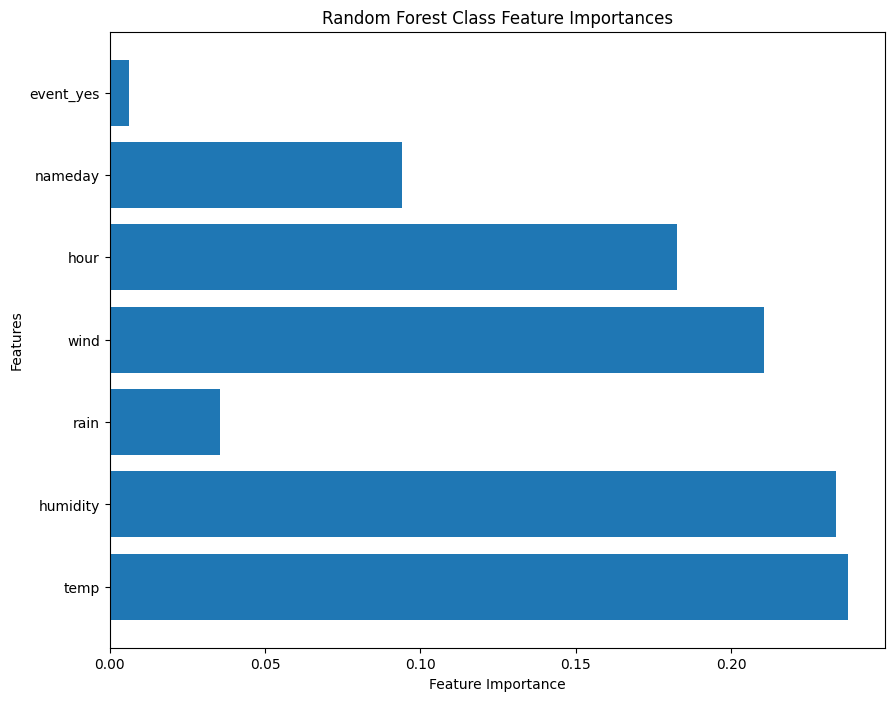

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.exceptions import NotFittedError
from sklearn.inspection import permutation_importance


# Define numeric and categorical features
numeric_features = ['temp', 'humidity', 'rain', 'wind']
categorical_features = ['hour', 'nameday', 'event_yes']

if 'target' in numeric_features:
    numeric_features.remove('target')

# Define transformers for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create pipeline with preprocessor and random forest regressor
rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestClassifier(n_estimators=300, random_state=42))
])

# Fit the pipeline on the training data
rfc.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rfc = rfc.predict(X_test)

# Fit the OneHotEncoder transformer to the categorical features
categorical_transformer.fit(X_train[categorical_features])

# Get feature importances and names
importances = rfc.named_steps['regressor'].feature_importances_
encoded_cat_features = categorical_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(encoded_cat_features)
feature_importances = np.zeros(len(all_feature_names))

# Add the importances of the original numeric features
feature_importances[:len(numeric_features)] += importances[:len(numeric_features)]

# Combine the importances of the encoded categorical features into the original features
feature_importances = importances[:len(numeric_features)].tolist()  # Start with the numeric features
for i, feature_name in enumerate(categorical_features):
    encoded_cat_importances = [
        importances[j] for j, feat_name in enumerate(all_feature_names)
        if feat_name.startswith(feature_name + '_')
    ]
    feature_importances.append(sum(encoded_cat_importances))

# Get the names of the original features
original_feature_names = numeric_features + categorical_features

# Plot the feature importances
plt.figure(figsize=(10,8))
plt.barh(original_feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Class Feature Importances')
plt.show()

In [16]:
from sklearn.metrics import classification_report

# Generate predictions on the test set
y_pred_rfc = rfc.predict(X_test)

# Create a classification report
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

        High       0.48      0.09      0.15       316
Intermediate       0.71      0.97      0.82      1509
         Low       0.60      0.11      0.19       344

    accuracy                           0.70      2169
   macro avg       0.60      0.39      0.39      2169
weighted avg       0.66      0.70      0.62      2169



# Trial on realtime data



In [67]:
# df = pd.read_csv("routes.csv")
os.chdir("/content/drive/MyDrive/modern_data_analysis")

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
content = "https://weather.com/weather/hourbyhour/l/c097b546627cdff2da1e276cb9b2731055718a5e7270d777a92857a9701c7870"
response = requests.get(content)
soup = BeautifulSoup(response.content, 'html.parser')

temp_val = soup.findAll('div', attrs={'class':'DetailsTable--field--CPpc_'})


forecast = pd.DataFrame()
forecast['temp'] = [round((int(temp_val[i].text[-3:-1])-32 ) *5/9, 1) for i in list(np.array(range(288))) if i%6 == 0]
forecast['wind'] = [float(temp_val[i].text.split(' ')[1]) for i in list(np.array(range(288))) if i%6 == 1]
forecast['wind_direction'] = [temp_val[i].text.split(' ')[0] for i in list(np.array(range(288))) if i%6 == 1]
forecast['humidity'] = [int(temp_val[i].text[-3:-1]) for i in list(np.array(range(288))) if i%6 == 2]
forecast['cloud_cover'] = [int(temp_val[i].text.replace('Cloud Cover', '')[:-1]) for i in list(np.array(range(288))) if i%6 == 4]
forecast['rain'] = [int(temp_val[i].text.replace('Rain Amount', '').replace(' in', '')) for i in list(np.array(range(288))) if i%6 == 5]
weekday = [(datetime.now()+timedelta(hours=i)).weekday() for i in range(48)]
hour_of_day = [(datetime.now()+timedelta(hours=i)).hour for i in range(48)]
forecast['nameday'] = weekday
forecast['hour'] = hour_of_day
forecast['event_yes'] = '' # This value has to be included by the user. So edit this. The value now is missing, but the model running, so even if nothing is provided, it will run
forecast['tag_category'] = '' # This value has to be included by the user. So edit this


In [4]:
# Generate predictions on the test set
prediction_app = rfc.predict(forecast)

In [5]:
prediction_app

array(['Intermediate', 'Intermediate', 'High', 'High', 'High', 'High',
       'Intermediate', 'Intermediate', 'Intermediate', 'High',
       'Intermediate', 'Intermediate', 'Intermediate', 'Intermediate',
       'Intermediate', 'Intermediate', 'Intermediate', 'Intermediate',
       'Intermediate', 'Intermediate', 'Intermediate', 'Intermediate',
       'Intermediate', 'Intermediate', 'Intermediate', 'Intermediate',
       'Intermediate', 'Intermediate', 'High', 'High', 'High', 'High',
       'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High',
       'High', 'High', 'High', 'High', 'High', 'Intermediate', 'High',
       'High'], dtype=object)

# Saving the trained model

In [1]:
import plotly.graph_objects as go
import pickle
with open('classifier_trained_model.pkl', 'rb') as f:
    rfc = pickle.load(f)

In [21]:
with open('classifier_trained_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)

In [6]:
colors = {"Low": "green", "Intermediate": "yellow", "High": "red"}
